In [126]:
"""
Creating a Trigram based Neural Network
In this section, we are performing the following tasks:
    1.  Importing the dataset(data)
    2.  Shuffling the dataset
    3.  Dividing it into train-dev-test(80-10-10) split 
"""

import torch
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
words = open('names.txt', 'r').read().splitlines()


In [127]:
"""
Creating a string to index and index to string mapping
"""
def build_character_mappings(words):
    chars = sorted(list(set(''.join(words)))) # Contains the list of all the alphabets in asending order
    stoi = {s: i+1 for i,s in enumerate(chars)} # contains the string to index mapping
    stoi['.'] = 0 # Signifies the start/end of a word
    itos = {i:s for s,i in stoi.items()} # contans the index to string mapping
    return {'stoi': stoi, 'itos': itos}

character_mappings = build_character_mappings(words)
stoi = character_mappings['stoi']
itos = character_mappings['itos']


In [128]:
# Create the dataset
def convert_words_to_index(data, stoi):
    xs, ys = [], []
    for w in data:    
        chs = ['.'] + list(w) + ['.']
        for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
            ix1 = stoi[ch1]
            ix2 = stoi[ch2]
            ix3 = stoi[ch3]
            xs.append(ix1 * 27 + ix2)
            ys.append(ix3)

    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    # num = xs.nelement()
    return {'xs': xs, 'ys': ys}

dataset = convert_words_to_index(words, stoi)

In [129]:
def train_test_dev_split(dataset):
    # Defining the split ratio train-dev-test 80: 10: 10
    n_size = dataset['xs'].size(0)
    n_train = int(0.8 * n_size)
    n_dev = int(0.1 * n_size)
    n_test = n_size - n_train - n_dev

    # Shuffle the data
    perm = torch.randperm(n_size)
    xs_shuffled = dataset['xs'][perm]
    ys_shuffled = dataset['ys'][perm]

    # Split the input data
    train_x = xs_shuffled[:n_train]
    dev_x = xs_shuffled[n_train:n_train + n_dev]
    test_x = xs_shuffled[n_train + n_dev:]

    # Split the labels
    train_y = ys_shuffled[:n_train]
    dev_y = ys_shuffled[n_train:n_train + n_dev]
    test_y = ys_shuffled[n_train + n_dev:]

    return {'train_x': train_x, 'train_y': train_y,
            'dev_x': dev_x, 'dev_y': dev_y,
            'test_x': test_x, 'test_y': test_y}

splitted_dataset = train_test_dev_split(dataset)
train_x = splitted_dataset['train_x'].to(device)
train_y = splitted_dataset['train_y'].to(device)
dev_x = splitted_dataset['dev_x'].to(device)
dev_y = splitted_dataset['dev_y'].to(device)
test_x = splitted_dataset['test_x'].to(device)
test_y = splitted_dataset['test_y'].to(device)


In [134]:
# Plot the training loss graph
def plot_losses(num_epochs, losses, type="Training"):
    plt.plot(range(1, NUM_EPOCHS + 1), losses, marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{type} Loss vs. Epoch")
    plt.grid(True)
    plt.show()


In [ ]:
"""
    1.  Initialize the Network: Randomly initialize 27 neurons' weights. 
    2.  Each neuron receives 27 inputs.
"""
g = torch.Generator(device='cuda').manual_seed(2147483647)
W = torch.randn((27 * 27, 27), generator=g, requires_grad=True, device=torch.device('cuda:0'))

Average train loss: 2.087879


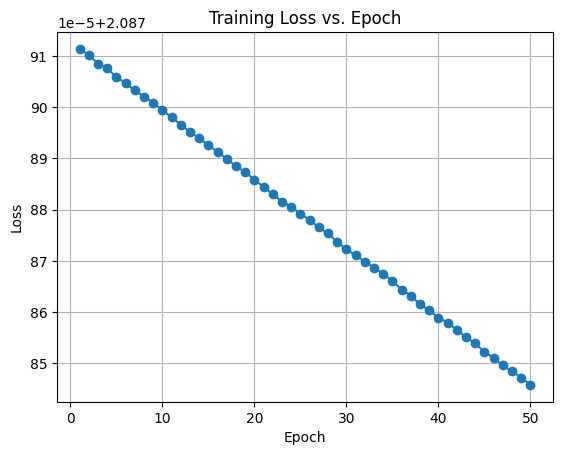

In [211]:
"""
In this sectiion, we are:
    1.  We are running the forward pass
    2.  Backward pass
    3.  Updating the weights
"""

NUM_EPOCHS = 50
WGT_UPDATE_COFF = 5
LOSS_COFF = 0.001
losses = []

for epoch in range(NUM_EPOCHS):
    # Forward Pass
    xenc = F.one_hot(train_x, num_classes=729).float() # Input to the network: one-hot encoding. O/P: Tensor(train_x, 729)
    logits = xenc @ W # predict log-counts: (228146, 729) @ (729, 27) => (228146, 27)
    counts = logits.exp() # counts, equivalent to N
    num = train_x.size(0)
    probs = counts / counts.sum(1, keepdims=True) # Probablities for next character
    loss = -probs[torch.arange(num), train_y].log().mean() + LOSS_COFF*(W**2).mean()
    losses.append(loss.item())

    # Backward pass
    W.grad = None # set to zero the gradient
    loss.backward()

    # Update
    W.data += -WGT_UPDATE_COFF * W.grad

train_loss = sum(losses) / len(losses)
print(f'Average train loss: {train_loss:4f}')
plot_losses(NUM_EPOCHS, losses)


In [212]:
# Performing a prediction on dev dataset using Trigram model
for i in range(5):
  out = []
  ix = 0
  while True:
    xenc = F.one_hot(torch.tensor([dev_x[0].item()], device=device), num_classes=729).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
    out.append(itos[ix.item()])
    if ix == 0:
      break
  print(''.join(out))

oerioioyiriadqardsehaheraeilieiiiydydialigadii.
yaaoellaiiioidieyaedaado.
yrayei.
r.
iiroileaieiiyeoha.


In [213]:
# Checking loss on dev dataset
xenc = F.one_hot(dev_x, num_classes=729).float() # Input to the network: one-hot encoding. O/P: Tensor(train_x, 729)
logits = xenc @ W # predict log-counts: (228146, 729) @ (729, 27) => (228146, 27)
counts = logits.exp() # counts, equivalent to N
num = dev_x.size(0)
probs = counts / counts.sum(1, keepdims=True) # Probablities for next character
loss = -probs[torch.arange(num), dev_y].log().mean() + LOSS_COFF*(W**2).mean()
dev_loss = loss.item()
print(f'Dev dataset:', f'{dev_loss:.4f}')
print(f'Result: {dev_loss - train_loss}')

Dev dataset: 2.1262
Result: 0.03830639839172356


In [214]:
# Checking loss on test dataset
xenc = F.one_hot(test_x, num_classes=729).float() # Input to the network: one-hot encoding. O/P: Tensor(train_x, 729)
logits = xenc @ W # predict log-counts: (228146, 729) @ (729, 27) => (228146, 27)
counts = logits.exp() # counts, equivalent to N
num = test_x.size(0)
probs = counts / counts.sum(1, keepdims=True) # Probablities for next character
loss = -probs[torch.arange(num), test_y].log().mean() + LOSS_COFF*(W**2).mean()
dev_loss = loss.item()
print(f'Test dataset:', f'{dev_loss:.4f}')
print(f'Result: {dev_loss - train_loss}')

Test dataset: 2.1331
Result: 0.04523555755615227
